In [47]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch, torchvision
from scipy import stats

from z0inf.approximation import zsinf

import warnings
warnings.filterwarnings('ignore')

In [27]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

train_all_fixed_dl = torch.utils.data.DataLoader(trainset, batch_size=128,
                                                     shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_all_fixed_dl = torch.utils.data.DataLoader(testset, batch_size=128,
                                                     shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Self-Influence

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
z_self_mean = zsinf.z_self_inf_mean(torch.load('data/exp-results/train_losses.pt'))
z_self_var = zsinf.z_self_inf_var(torch.load('data/exp-results/train_losses.pt'))

### Self-influence using finite differences method

Since calling `z_self_inf_finite_diff` can take a bit longer, we save the results and load them here

In [30]:
# Run the following command in terminal to compute z_self_finite_diff

# python -m z0inf.approximation.zsinf --method finite_diff \
#                                     --weights_path data/exp-results/all_weights.pt \
#                                     --losses_path data/exp-results/train_losses.pt \
#                                     --save_fl data/exp-results/z_self_finite_diff_resnet18.pt \
#                                     --batch_size 512

z_self_finite_diff = torch.load('data/exp-results/z_self_finite_diff_resnet18.pt', map_location=torch.device('cpu'))

In [31]:
sorted_self_influences_var = torch.sort(z_self_var)
sorted_self_influences_mean = torch.sort(z_self_mean)
sorted_self_influences_mean

torch.return_types.sort(
values=tensor([1.0993e-03, 1.8586e-03, 1.9493e-03,  ..., 3.6660e+00, 3.8812e+00,
        4.2695e+00]),
indices=tensor([44664,   794, 23308,  ..., 16593, 13223, 18310]))

In [32]:
def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

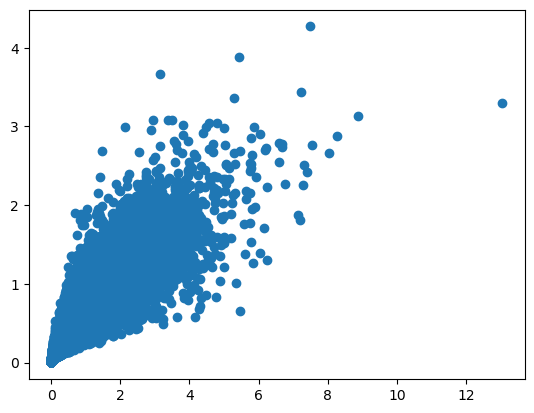

In [33]:
plt.plot(z_self_var, z_self_mean, 'o')

In [34]:
stats.spearmanr(z_self_var, z_self_mean)

SignificanceResult(statistic=np.float64(0.9420141505000331), pvalue=np.float64(0.0))

In [35]:
stats.spearmanr(z_self_finite_diff, z_self_mean)

SignificanceResult(statistic=np.float64(0.8526333360880071), pvalue=np.float64(0.0))

In [36]:
stats.spearmanr(z_self_finite_diff, z_self_var)

SignificanceResult(statistic=np.float64(0.8437588209177495), pvalue=np.float64(0.0))

# Train-Test Influence

Since it can take some time to compute train test influence. Let's run it on the command line using the following shell script.

In [37]:
## ZInf - Zeroth-Order Train-Test Influence


# python -m z0inf.approximation.zinf --weights_path data/exp-results/all_weights.pt \
#                                     --train_path data/exp-results/train_losses.pt \
#                                     --test_path data/exp-results/test_losses.pt \
#                                     --save_path data/exp-results/ \
#                                     --save_fl z_train_test_resnet18.pt \
#                                     --epochs 40



In [38]:
influences_x_corr = torch.load('data/exp-results/z_train_test_resnet18.pt', map_location=torch.device('cpu'))

In [39]:
top_vals, top_inds = torch.topk(influences_x_corr, 5, axis=0)

In [ ]:
tot_values, tot_indices = torch.topk(top_vals, axis=1, k=10)

(tensor([[2.8732e-19, 2.5789e-19, 2.4718e-19, 2.4031e-19, 2.3825e-19, 2.3402e-19,
          2.3100e-19, 2.2693e-19, 2.2527e-19, 2.2423e-19],
         [2.7031e-19, 2.1892e-19, 2.1611e-19, 2.1406e-19, 2.1364e-19, 2.0760e-19,
          2.0688e-19, 1.9319e-19, 1.9116e-19, 1.8628e-19],
         [2.5461e-19, 2.1350e-19, 2.1346e-19, 2.1019e-19, 2.0270e-19, 1.9292e-19,
          1.8810e-19, 1.8090e-19, 1.7923e-19, 1.7646e-19],
         [2.5000e-19, 2.0905e-19, 2.0606e-19, 2.0105e-19, 1.8852e-19, 1.8316e-19,
          1.8183e-19, 1.7473e-19, 1.7455e-19, 1.6985e-19],
         [2.3728e-19, 2.0488e-19, 1.9791e-19, 1.9173e-19, 1.8141e-19, 1.8056e-19,
          1.7179e-19, 1.6793e-19, 1.6751e-19, 1.6640e-19]]),
 tensor([[4302, 5416, 8578, 3496, 4536, 6723, 5511, 3450, 5537, 7181],
         [4302, 5511, 5537, 8578, 5416, 3450, 9227,  354, 7181, 6381],
         [4302, 5511, 5416, 5537, 9227, 3450, 8578, 3560, 8573,  802],
         [4302, 5416, 5537, 9227, 3450, 5511, 8578,  802, 5411, 1131],
         

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].


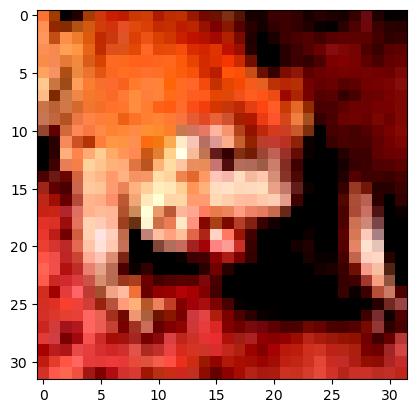

('test_img: ', 'frog')

In [43]:
test_index = 5

test_img, test_lbl  = testset[test_index]
test_lbl = classes[test_lbl]

imshow(torchvision.utils.make_grid(test_img))

'test_img: ', test_lbl

In [44]:
topk_indices = torch.topk(influences_x_corr[:,test_index], k=5).indices

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6894605..1.7085817].


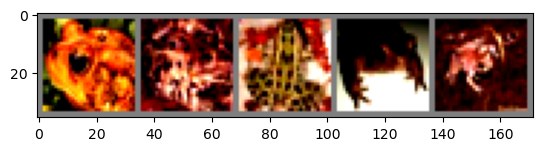

In [45]:
topk_train_images = [trainset[i][0] for i in topk_indices.tolist()]


imshow(torchvision.utils.make_grid(topk_train_images))

In [46]:
[classes[trainset[i][1]] for i in topk_indices.tolist()]

['frog', 'frog', 'frog', 'frog', 'frog']